# 1. Nhập dữ liệu

In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Lấy luôn dữ liệu đã loc của tác giả
test_dataset = pd.read_csv("data_for_modeling/HDAC3_test.csv")
train_dataset = pd.read_csv("data_for_modeling/HDAC3_train.csv")

# 2. Xây dựng mô hình với Morgan2

## 2.1. Mã hóa cấu trúc phân tử

In [4]:
def maccs_fpts(data):
    Maccs_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = MACCSkeys.GenMACCSKeys(mol)
        mfpts = np.array(fpts)
        Maccs_fpts.append(mfpts)
    return np.array(Maccs_fpts)

In [5]:
train_maccs_fpts = maccs_fpts(train_dataset['SMILES'])
test_maccs_fpts = maccs_fpts(test_dataset['SMILES'])

In [6]:
X_Train = train_maccs_fpts
X_Test = test_maccs_fpts
y_Train = np.array(train_dataset['Type'])
y_Test = np.array(test_dataset['Type'])

## 2.2. Xây dựng mô hình

__Random Forest Classifier__

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf_maccs = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_maccs.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=0)

__K Nearest Neighbor__

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_maccs = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_maccs.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [11]:
from sklearn.svm import SVC
svm_maccs = SVC(kernel='rbf', random_state=0)
svm_maccs.fit(X_Train, y_Train)

SVC(random_state=0)

__XGBoost__

In [13]:
from xgboost import XGBClassifier
bst_maccs = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_maccs.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 2.3. Đánh giá và so sánh mô hình của tác giả

### 2.3.1. 10-fold-cross validation

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [15]:
X_Total = np.concatenate((X_Train, X_Test), axis=0)
y_Total = np.concatenate((y_Train, y_Test), axis=0)

__RF__

In [16]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.854))

Độ chính xác của 10-fold cross validation: 0.837 (0.036)
So sánh với độ chính xác của bài báo là: 0.854


__KNN__

In [17]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(knn_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.843))

Độ chính xác của 10-fold cross validation: 0.824 (0.028)
So sánh với độ chính xác của bài báo là: 0.843


__SVM__

In [15]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(svm_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.842))

Độ chính xác của 10-fold cross validation: 0.825 (0.025)
So sánh với độ chính xác của bài báo là: 0.842


__XGBoost__

In [16]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(bst_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.829))

Độ chính xác của 10-fold cross validation: 0.850 (0.032)
So sánh với độ chính xác của bài báo là: 0.829


### 2.3.2. Accuracy, Sensitivity, Specificity

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [18]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [19]:
def me_result(cm, ac1, se1, sp1, mcc1):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], ['Shin Liu et at', ac1, se1, sp1, mcc1], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

RF

In [20]:
#Random Forest
y_rf_pred = rf_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_rf_pred)
ac1, se1, sp1, mcc1 = 0.884 ,0.942 ,0.746 ,0.715
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 44  15]
 [  5 134]]
Comparision:
╒════════════════╤═════════╤══════════╤══════════╤══════════╕
│                │      AC │       SE │       SP │      MCC │
╞════════════════╪═════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.884   │ 0.942    │ 0.746    │ 0.715    │
├────────────────┼─────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.89899 │ 0.897959 │ 0.899329 │ 0.752269 │
╘════════════════╧═════════╧══════════╧══════════╧══════════╛


KNN

In [21]:
#KNN
y_knn_pred = knn_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_knn_pred)
ac1, se1, sp1, mcc1 = 0.869 ,0.935 ,0.712 ,0.677
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 38  21]
 [  9 130]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.869    │ 0.935    │ 0.712    │ 0.677    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.848485 │ 0.808511 │ 0.860927 │ 0.622751 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


SVM

In [22]:
#SVM
y_svm_pred = svm_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_svm_pred)
ac1, se1, sp1, mcc1 = 0.879 ,0.942 ,0.729 ,0.702
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 40  19]
 [ 12 127]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.879    │ 0.942    │ 0.729    │ 0.702    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.843434 │ 0.769231 │ 0.869863 │ 0.614907 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


XGBoost

In [23]:
y_bst_pred = bst_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_bst_pred)
ac1, se1, sp1, mcc1 = 0.864, 0.950, 0.661, 0.661
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 44  15]
 [ 13 126]]
Comparision:
╒════════════════╤══════════╤═════════╤══════════╤══════════╕
│                │       AC │      SE │       SP │      MCC │
╞════════════════╪══════════╪═════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.864    │ 0.95    │ 0.661    │ 0.661    │
├────────────────┼──────────┼─────────┼──────────┼──────────┤
│ My model       │ 0.858586 │ 0.77193 │ 0.893617 │ 0.658859 │
╘════════════════╧══════════╧═════════╧══════════╧══════════╛


### 2.3.3. AUC

In [24]:
from sklearn.metrics import RocCurveDisplay

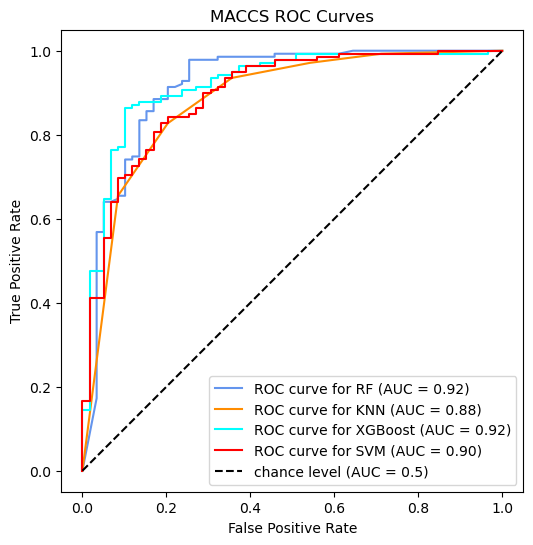

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MACCS ROC Curves")
plt.legend()
plt.show()